# Vectorized Backtest

In [132]:
import warnings
warnings.filterwarnings('ignore')

In [133]:
from pathlib import Path
from time import time
import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [134]:
sns.set_style('whitegrid')
np.random.seed(42)

## Load Data

### Return Predictions

In [135]:
DATA_DIR = Path('..', 'data')

In [136]:
data = pd.read_hdf('00_data/backtest.h5', 'data')
data.info()
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 190451 entries, ('AAPL', Timestamp('2014-12-09 00:00:00')) to ('LNG', Timestamp('2017-11-30 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   predicted  74054 non-null   float64
 1   open       190451 non-null  float64
 2   high       190451 non-null  float64
 3   low        190451 non-null  float64
 4   close      190451 non-null  float64
 5   volume     190451 non-null  float64
dtypes: float64(6)
memory usage: 10.2+ MB


predicted        open        high         low       close  \
ticker date                                                                    
AAPL   2014-12-09  -0.001727  104.680961  108.585478  103.882957  108.414477   
       2014-12-10  -0.001063  108.689978  109.107980  105.963466  106.352968   
       2014-12-11  -0.001225  106.647469  108.110476  105.773466  106.039467   
       2014-12-12  -0.000943  104.937462  106.276968  104.101458  104.243959   
       2014-12-15  -0.001251  105.165463  106.020467  101.032945  102.814203   
...                      ...         ...         ...         ...         ...   
LNG    2017-11-24        NaN   47.520000   48.410000   47.520000   47.960000   
       2017-11-27        NaN   48.000000   48.210000   46.955000   47.190000   
       2017-11-28        NaN   47.520000   47.640000   46.960000   47.600000   
       2017-11-29        NaN   47.750000   48.130000   46.890000   48.000000   
       2017-11-30        NaN   48.000000   48.890000   48.000000   48.320000   

                       volume  
ticker date                    
AAPL   2014-12-09  60208036.0  
       2014-12-10  44565318.0  
       2014-12-11  41471578.0  
       2014-12-12  56028138.0  
       2014-12-15  67218082.0  
...                       ...  
LNG    2017-11-24    697313.0  
       2017-11-27   1060879.0  
       2017-11-28   1170273.0  
       2017-11-29   1398839.0  
       2017-11-30   1862026.0  

[190451 rows x 6 columns]

### SP500 Benchmark

A vectorized backtest is the most basic way to evaluate a strategy. It simply multiplies a signal vector that represents the target position size with a vector of returns for the investment horizon to compute the period performance.

Let's illustrate the vectorized approach using the daily return predictions that we created using ridge regression in the previous chapter. Using a few simple technical factors, we predicted the returns for the next day for the 100 stocks with the highest recent dollar trading volume (see Chapter 7, Linear Models – From Risk Factors to Return Forecasts, for details).

We'll transform the predictions into signals for a very simple strategy: on any given trading day, we will go long on the 10 highest positive predictions and go short on the lowest 10 negative predictions. If there are fewer positive or negative predictions, we'll hold fewer long or short positions. The notebook vectorized_backtest contains the following code example, and the script data.py creates the input data stored in backtest.h5.

First, we load the data for our strategy, as well as S&P 500 prices (which we convert into daily returns) to benchmark the performance:

In [137]:
sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()

In [138]:
sp500.info()
sp500

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 673 entries, 2015-06-04 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   672 non-null    float64
dtypes: float64(1)
memory usage: 10.5 KB


,SP500
DATE,
2015-06-04,NaN
2015-06-05,-0.001436
2015-06-08,-0.006474
2015-06-09,0.000418
2015-06-10,0.012042
...,...
2017-12-26,-0.001058
2017-12-27,0.000791
2017-12-28,0.001834


## Compute Forward Returns

The data combines daily return predictions and OHLCV market data for 253 distinct stocks over the 2014-17 period, with 100 equities for each day. Now, we can compute the daily forward returns and convert these and the predictions into wide format, with one ticker per column:

In [139]:
daily_returns = data.open.unstack('ticker').sort_index().pct_change()
daily_returns.info()
daily_returns


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2014-12-09 to 2017-11-30
Columns: 257 entries, AAPL to LNG
dtypes: float64(257)
memory usage: 1.5 MB


ticker,AAPL,ABBV,ADBE,AET,AGN,AIG,ALXN,AMAT,AMD,AMGN,...,ARNC,LL,EMR,DFS,SWN,URI,RIG,SDRL,HTZ,LNG
date,,,,,,,,,,,,,,,,,,,,,
2014-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-10,0.038297,0.018033,0.003084,0.006642,0.005251,0.004907,0.015573,0.009532,0.011765,-0.007750,...,0.003769,0.010691,0.009239,0.006075,0.007931,0.004040,0.000000,0.006855,0.015531,0.023963
2014-12-11,-0.018792,-0.042627,-0.020402,-0.027063,-0.009914,-0.007596,-0.017915,-0.020115,-0.027132,-0.013609,...,-0.021902,-0.021969,-0.024148,-0.020282,-0.007527,-0.008779,-0.022334,-0.050213,-0.032710,-0.039904
2014-12-12,-0.016034,0.000752,0.058060,0.008161,-0.001386,0.000182,-0.028599,-0.009217,-0.019920,-0.021356,...,-0.039028,-0.021631,-0.023209,-0.007743,-0.014478,-0.031091,-0.036551,-0.018817,-0.028546,-0.013750
2014-12-15,0.002173,-0.011724,0.020089,0.004104,0.000771,-0.007653,-0.002387,0.007188,0.024390,0.009991,...,0.002663,0.008844,-0.024257,-0.011785,0.013991,-0.038183,-0.002964,0.010046,-0.032550,0.036755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-24,0.010037,-0.007287,-0.007378,-0.001020,0.023392,-0.001679,-0.003510,-0.018493,-0.002629,-0.002119,...,0.002522,-0.022933,0.020247,-0.001066,0.000000,-0.006468,0.000000,-0.014925,-0.012994,-0.010412
2017-11-27,-0.000286,0.007340,0.010221,-0.003119,-0.008057,-0.006054,0.007138,-0.016076,-0.003515,0.006254,...,0.002935,-0.003912,-0.005808,-0.001220,0.000000,-0.004752,0.000000,0.053636,-0.010971,0.010101
2017-11-28,-0.004284,0.013201,0.004274,0.003470,-0.002880,-0.005753,-0.001289,0.001405,0.009700,0.000059,...,-0.008779,-0.018208,0.016228,-0.001069,0.000000,0.007457,0.000000,-0.089157,0.032723,-0.010000


In [140]:
fwd_returns = daily_returns.shift(-1)
fwd_returns

ticker,AAPL,ABBV,ADBE,AET,AGN,AIG,ALXN,AMAT,AMD,AMGN,...,ARNC,LL,EMR,DFS,SWN,URI,RIG,SDRL,HTZ,LNG
date,,,,,,,,,,,,,,,,,,,,,
2014-12-09,0.038297,0.018033,0.003084,0.006642,0.005251,0.004907,0.015573,0.009532,0.011765,-0.007750,...,0.003769,0.010691,0.009239,0.006075,0.007931,0.004040,0.000000,0.006855,0.015531,0.023963
2014-12-10,-0.018792,-0.042627,-0.020402,-0.027063,-0.009914,-0.007596,-0.017915,-0.020115,-0.027132,-0.013609,...,-0.021902,-0.021969,-0.024148,-0.020282,-0.007527,-0.008779,-0.022334,-0.050213,-0.032710,-0.039904
2014-12-11,-0.016034,0.000752,0.058060,0.008161,-0.001386,0.000182,-0.028599,-0.009217,-0.019920,-0.021356,...,-0.039028,-0.021631,-0.023209,-0.007743,-0.014478,-0.031091,-0.036551,-0.018817,-0.028546,-0.013750
2014-12-12,0.002173,-0.011724,0.020089,0.004104,0.000771,-0.007653,-0.002387,0.007188,0.024390,0.009991,...,0.002663,0.008844,-0.024257,-0.011785,0.013991,-0.038183,-0.002964,0.010046,-0.032550,0.036755
2014-12-15,-0.039115,-0.009734,-0.036875,-0.017713,0.013487,-0.025891,-0.035627,-0.027288,-0.031746,-0.043030,...,-0.001328,0.019555,-0.011539,-0.020951,-0.040359,-0.022572,-0.036861,-0.019892,-0.001869,-0.068612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-24,-0.000286,0.007340,0.010221,-0.003119,-0.008057,-0.006054,0.007138,-0.016076,-0.003515,0.006254,...,0.002935,-0.003912,-0.005808,-0.001220,0.000000,-0.004752,0.000000,0.053636,-0.010971,0.010101
2017-11-27,-0.004284,0.013201,0.004274,0.003470,-0.002880,-0.005753,-0.001289,0.001405,0.009700,0.000059,...,-0.008779,-0.018208,0.016228,-0.001069,0.000000,0.007457,0.000000,-0.089157,0.032723,-0.010000
2017-11-28,-0.009581,-0.001876,-0.009428,0.008503,0.016812,0.023485,-0.006083,-0.002456,-0.032314,0.002521,...,0.022775,0.020364,0.022996,0.039437,0.000000,0.012855,0.000000,0.007262,-0.012352,0.004840


## Generate Signals

In [141]:
predictions = data.predicted.unstack('ticker')
predictions.info()
predictions

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2014-12-09 to 2017-04-14
Columns: 257 entries, AAPL to LNG
dtypes: float64(257)
memory usage: 1.5 MB


ticker,AAPL,ABBV,ADBE,AET,AGN,AIG,ALXN,AMAT,AMD,AMGN,...,ARNC,LL,EMR,DFS,SWN,URI,RIG,SDRL,HTZ,LNG
date,,,,,,,,,,,,,,,,,,,,,
2014-12-09,-0.001727,0.001195,NaN,NaN,0.002030,-0.000461,NaN,NaN,NaN,0.001364,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000397,NaN,-0.005228,NaN
2014-12-10,-0.001063,0.000259,NaN,NaN,0.001740,-0.001381,NaN,NaN,NaN,0.000895,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002183,NaN,-0.003744,NaN
2014-12-11,-0.001225,0.000223,NaN,NaN,0.000543,-0.001174,NaN,NaN,NaN,0.000273,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001639,NaN,-0.004773,NaN
2014-12-12,-0.000943,0.000637,NaN,NaN,0.000495,-0.001333,NaN,NaN,NaN,0.000985,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002674,NaN,-0.003588,NaN
2014-12-15,-0.001251,0.000461,NaN,NaN,-0.000683,-0.001441,NaN,NaN,NaN,0.001362,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001579,NaN,-0.004493,0.000991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-28,-0.001654,-0.001064,-0.000371,-0.001769,-0.002168,-0.000505,NaN,0.000758,-0.000845,-0.001584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29,-0.002464,-0.000991,-0.002488,-0.002021,-0.001524,-0.000816,NaN,-0.001659,-0.000382,-0.001050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The next step is to select positive and negative predictions, rank them in descending and ascending fashion, and create long and short signals using an integer mask that identifies the top 10 on each side with identifies the predictions outside the top 10 with a one, and a zero:

In [142]:
N_LONG = N_SHORT = 50

In [143]:
long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) > N_SHORT)
                 .astype(int))

In [144]:
long_signals

ticker,AAPL,ABBV,ADBE,AET,AGN,AIG,ALXN,AMAT,AMD,AMGN,...,ARNC,LL,EMR,DFS,SWN,URI,RIG,SDRL,HTZ,LNG
date,,,,,,,,,,,,,,,,,,,,,
2014-12-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-11-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
short_signals

ticker,AAPL,ABBV,ADBE,AET,AGN,AIG,ALXN,AMAT,AMD,AMGN,...,ARNC,LL,EMR,DFS,SWN,URI,RIG,SDRL,HTZ,LNG
date,,,,,,,,,,,,,,,,,,,,,
2014-12-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2014-12-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-28,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-11-29,0,1,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2017-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Compute Portfolio Returns

We can then multiply the binary DataFrames with the forward returns (using their negative inverse for the shorts) to get the daily performance of each position, assuming equal-sized investments. The daily average of these returns corresponds to the performance of equal-weighted long and short portfolios, and the sum reflects the overall return of a market-neutral long-short strategy:

#### 1. **Calculating Long Returns**
```python
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
```
- **`long_signals.mul(fwd_returns)`**:
  - Multiplies the `long_signals` DataFrame (0s and 1s) element-wise with `fwd_returns`.
  - For each stock on each day:
    - If the signal is 1, the forward return is included (e.g., if the stock returns 2%, you get 2%).
    - If the signal is 0, the result is 0 (no position taken).
  - This creates a DataFrame where only the returns of stocks selected for long positions are retained.
- **`.mean(axis=1)`**:
  - Takes the average across all stocks (along `axis=1`) for each day.
  - Since only stocks with a signal of 1 contribute non-zero values, this computes the average return of the long portfolio for that day.
  - Example: If 10 stocks are long with returns [2%, 1%, ..., 3%], the long return for that day is their average.

#### 2. **Calculating Short Returns**
```python
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
```
- **`short_signals.mul(-fwd_returns)`**:
  - Multiplies the `short_signals` DataFrame (0s and 1s) element-wise with the negative of `fwd_returns`.
  - For short positions, you profit when the stock price decreases, so `-fwd_returns` flips the sign:
    - If a stock drops by 2% (return = -2%), shorting it yields +2%.
    - If the signal is 1, you get this positive return; if 0, you get 0.
  - This simulates the returns from shorting the selected stocks.
- **`.mean(axis=1)`**:
  - Averages these values across all stocks for each day, giving the average return of the short portfolio.
  - Example: If 10 stocks are shorted and their returns are [-1%, -2%, ..., -3%], the short return is the average of [1%, 2%, ..., 3%].

#### 3. **Combining into Strategy Returns**
```python
strategy = long_returns.add(short_returns).to_frame('strategy')
```
- **`long_returns.add(short_returns)`**:
  - Adds the daily average long returns and short returns to compute the total strategy return for each day.
  - This reflects the performance of a market-neutral long-short strategy, where gains from long positions (positive returns) and short positions (negative returns flipped positive) are combined.
- **`.to_frame('strategy')`**:
  - Converts the resulting pandas Series (one value per day) into a DataFrame with a single column named `'strategy'`, suitable for further analysis or plotting.

---

### What It Represents
- **Long Portfolio**: The average daily return from equally weighted long positions in the top predicted stocks.
- **Short Portfolio**: The average daily return from equally weighted short positions in the bottom predicted stocks.
- **Strategy**: The sum of these averages, representing the overall return of the long-short strategy. Since it’s market-neutral, it doesn’t depend on the overall market direction but on the relative performance of the selected stocks.

---

### Example
Suppose on a given day:
- `fwd_returns` for 5 stocks: [2%, -1%, 3%, -2%, 1%]
- `long_signals`: [1, 0, 1, 0, 0] (long on stocks 1 and 3)
- `short_signals`: [0, 1, 0, 1, 0] (short on stocks 2 and 4)

1. **Long Returns**:
   - `long_signals.mul(fwd_returns)`: [2%, 0%, 3%, 0%, 0%]
   - `.mean(axis=1)`: (2% + 0% + 3% + 0% + 0%) / 5 = 1% (or over 2 stocks = 2.5%, depending on implementation)

2. **Short Returns**:
   - `-fwd_returns`: [-2%, 1%, -3%, 2%, -1%]
   - `short_signals.mul(-fwd_returns)`: [0%, 1%, 0%, 2%, 0%]
   - `.mean(axis=1)`: (0% + 1% + 0% + 2% + 0%) / 5 = 0.6% (or over 2 stocks = 1.5%)

3. **Strategy**:
   - `long_returns + short_returns`: 1% + 0.6% = 1.6% (or 2.5% + 1.5% = 4%)
   - Stored as a DataFrame: `{'strategy': 1.6%}` for that day.

---

### Summary
This code efficiently computes the daily returns of a long-short strategy using vectorized operations:
- **Long positions** profit from stocks predicted to rise.
- **Short positions** profit from stocks predicted to fall.
- The **total return** is the sum of the average long and short portfolio returns, assuming equal weighting across positions. This approach is fast and scalable for large datasets, avoiding the need for loops over stocks or days.

In [146]:
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

## Plot results

When we compare the results, as shown in Figure 8.2, our strategy performed well compared to the S&P 500 for the first 2 years of the period – that is, until the benchmark catches up and our strategy underperforms during 2017.

The strategy returns are also less volatile with a standard deviation of 0.002 compared to 0.008 for the S&P 500; the correlation is low and negative at -0.093:

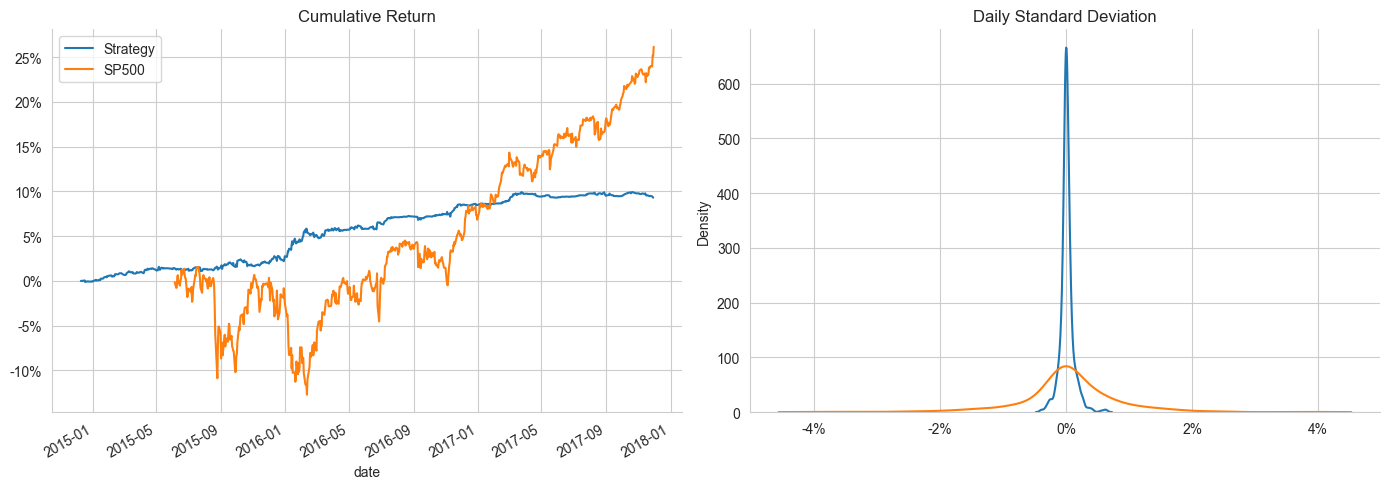

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(sp500, ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [148]:
res = strategy.join(sp500).dropna()

In [149]:
res.std()

Strategy    0.001125
SP500       0.007874
dtype: float64

In [150]:
res.corr()

,Strategy,SP500
Strategy,1.000000,-0.095726
SP500,-0.095726,1.000000


While this approach permits a quick back-of-the-envelope evaluation, it misses important features of a robust, realistic, and user-friendly backtest engine; for example:

- We need to manually align the timestamps of predictions and returns (using pandas' built-in capabilities) and do not have any safeguards against inadvertent look-ahead bias.
- There is no explicit position sizing and representation of the trading process that accounts for costs and other market realities, or an accounting system that tracks positions and their performance.
- There is also no performance measurement other than what we compute after the fact, and risk management rules like stop-loss are difficult to simulate.

That's where event-driven backtesting comes in. An event-driven backtesting engine explicitly simulates the time dimension of the trading environment and imposes significantly more structure on the simulation. This includes the use of historical calendars that define when trades can be made and when quotes are available. The enforcement of timestamps also helps to avoid look-ahead bias and other implementation errors mentioned in the previous section (but there is no guarantee).

Generally, event-driven systems aim to capture the actions and constraints encountered by a strategy more closely and, ideally, can readily be converted into a live trading engine that submits actual orders.